In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder

target_col = "label"  # "status"
ok_val = 1  # "OK"


df = pd.read_csv("train.csv")
to_drop = ["physical_part_id", "message_timestamp"]
for c in df.columns:
    if df[c].isna().all():
        to_drop.append(c)
df = df.drop(columns=to_drop)
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
categorical_features = [c for c in df.columns if "sensor" not in c]
df = pd.get_dummies(df, columns=categorical_features)
df.head()


,s6_sensor0_millimeter_step1,s8_sensor0_millimeter_step1,s8_sensor1_millimeter_step1,s7_sensor0_newton_step1,s9_sensor0_kilonewton_step1,s7_sensor1_mikrometer_step1,s0_sensor0_kilonewton_step3,s2_sensor0_millimeter_step1,s9_sensor1_sekunden (zeit)_step1,s8_sensor2_millimeter_step1,...,physical_part_type_type4,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,shift_Fruehschicht,shift_Nachtschicht,shift_Spaetschicht
0,4606.469076,20.936714,390.550800,8856.466834,36.836737,32226.284706,NaN,19.696395,1056.249745,7.556479,...,False,False,False,False,False,True,False,True,False,False
1,4606.469076,18.293964,378.279734,8860.946584,36.836737,32700.200657,NaN,17.763653,1056.249745,7.119582,...,False,True,False,False,False,False,False,True,False,False
2,5886.043819,20.944510,428.742769,8849.747208,36.836737,32429.391542,-53.537243,19.582187,1056.249745,9.377910,...,False,False,False,False,False,True,False,True,False,False
3,4606.469076,18.475864,373.095553,8845.267457,36.836737,32564.796100,NaN,18.238053,1056.249745,7.541095,...,False,False,False,False,True,False,False,True,False,False
4,4606.469076,19.801137,382.829679,8847.507333,36.836737,33309.521166,NaN,19.178068,1013.999755,8.282590,...,False,False,True,False,False,False,False,False,False,True


In [2]:
target.mean()


0.9492512891709639

In [3]:
# Take 90% of data for training
df_train = df.sample(frac=0.9, random_state=42)
df_val = df.drop(df_train.index)
target_train = target.iloc[df_train.index]
target_val = target.iloc[df_val.index]

print(df_train.shape, df_val.shape)


(36302, 365) (4034, 365)


In [4]:
import warnings

warnings.filterwarnings(
    "ignore", category=UserWarning, module="sklearn.preprocessing._discretization"
)

discretizers = {}
encoders = {}
for i, col in enumerate(df_train.columns):
    if "sensor" in col:
        discretizer = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
        train_nan = df_train[col].isna()
        train_values = df_train[col].fillna(df_train[col].mean()).values.reshape(-1, 1)
        val_nan = df_val[col].isna()
        val_values = df_val[col].fillna(df_train[col].mean()).values.reshape(-1, 1)
        train_values = discretizer.fit_transform(train_values).ravel()
        train_values[train_nan] = -1
        val_values = discretizer.transform(val_values).ravel()
        val_values[val_nan] = -1
        df_train[col] = train_values
        df_train[col + "_nan"] = train_nan
        df_val[col] = val_values
        df_val[col + "_nan"] = val_nan
        discretizers[col] = discretizer

    if i % 10 == 0:
        df_train = df_train.copy()
        df_val = df_val.copy()

for col in df_train.columns:
    encoder = OrdinalEncoder()
    train_values = df_train[col].values.reshape(-1, 1)
    val_values = df_val[col].values.reshape(-1, 1)
    train_values = encoder.fit_transform(train_values).ravel()
    val_values = encoder.transform(val_values).ravel()
    df_train[col] = train_values
    df_val[col] = val_values
    encoders[col] = encoder

df_train = df_train.copy()
df_val = df_val.copy()


In [5]:
# for it, col in enumerate(df_train.columns):
#     df_train[col + "_nan"] = df_train[col].isna()
#     df_val[col + "_nan"] = df_val[col].isna()
#     if it % 10 == 0:
#         df_train = df_train.copy()
#         df_val = df_val.copy()
X_train = df_train.values
y_train = target_train.values
X_val = df_val.values
y_val = target_val.values

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)


(36302, 718) (36302,) (4034, 718) (4034,)


In [6]:
# imputer = SimpleImputer(strategy="constant", fill_value=0)
# X_train = imputer.fit_transform(X_train)
# X_val = imputer.transform(X_val)


In [8]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

solver = StackingClassifier(
    estimators=[
        ("nb", CategoricalNB()),
        ("logreg", LogisticRegression(max_iter=500)),
        ("xgb", XGBClassifier()),
        ("lgbm", LGBMClassifier()),
        ("catboost", CatBoostClassifier()),
    ],
    final_estimator=LogisticRegression(max_iter=500),
)
solver.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 34483, number of negative: 1819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2110
[LightGBM] [Info] Number of data points in the train set: 36302, number of used features: 718
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.949893 -> initscore=2.942180
[LightGBM] [Info] Start training from score 2.942180
Learning rate set to 0.047756
0:	learn: 0.6316543	total: 66ms	remaining: 1m 5s
1:	learn: 0.5774002	total: 76.2ms	remaining: 38s
2:	learn: 0.5296488	total: 86.6ms	remaining: 28.8s
3:	learn: 0.4884002	total: 95.3ms	remaining: 23.7s
4:	learn: 0.4527323	total: 102ms	remaining: 20.3s
5:	learn: 0.4215593	total: 111ms	remaining: 18.4s
6:	learn: 0.3943120	total: 121ms	remaining: 17.2s
7:	learn: 0.3704032	total: 130ms	remaining: 16.1s
8:	learn: 0.34

StackingClassifier(estimators=[('nb', CategoricalNB()),
                               ('logreg', LogisticRegression(max_iter=500)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_poli...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lgbm', LGBMClassifier()),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x147f2a5c0>)],
                   final_estimator=LogisticRegression(max_iter=500))

In [146]:
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier

# xgb_tree = XGBClassifier()
# lgbm_tree = LGBMClassifier()
# catboost_tree = CatBoostClassifier()
# logreg = LogisticRegression()
# mlp = MLPClassifier()
# solver = VotingClassifier(
#     estimators=[
#         ("xgb", xgb_tree),
#         ("lgbm", lgbm_tree),
#         ("catboost", catboost_tree),
#         ("logreg", logreg),
#         ("mlp", mlp),
#     ],
#     voting="soft",
# )
# solver.fit(X_train, y_train)


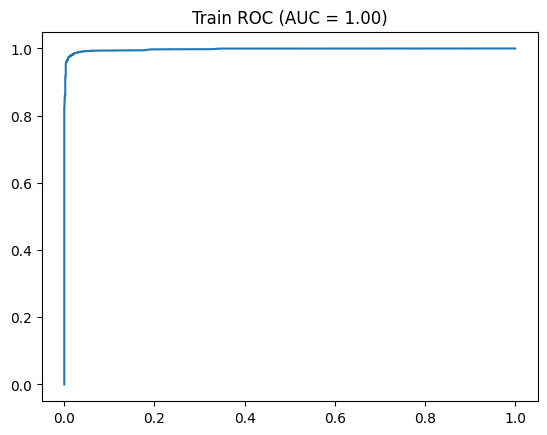

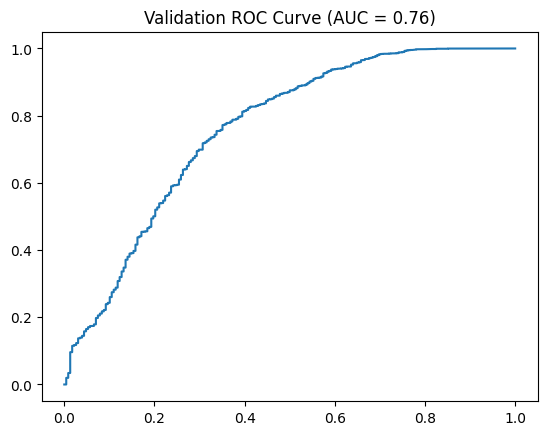

In [9]:
# Plot ROC curve on train
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = solver.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = solver.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()


In [13]:
test_df = pd.read_csv("test.csv")
test_df = test_df.drop(columns=to_drop)
test_df = pd.get_dummies(test_df, columns=categorical_features)

for i, col in enumerate(test_df.columns):
    if "sensor" in col:
        discretizer = discretizers[col]
        test_nan = test_df[col].isna()
        test_values = test_df[col].fillna(test_df[col].mean()).values.reshape(-1, 1)
        test_values = discretizer.transform(test_values).ravel()
        test_values[test_nan] = -1
        test_df[col] = test_values
        test_df[col + "_nan"] = test_nan
    if i % 10 == 0:
        test_df = test_df.copy()

for col in test_df.columns:
    encoder = encoders[col]
    test_df[col] = encoder.transform(test_df[col].values.reshape(-1, 1)).ravel()

X_test = test_df.values
y_pred = solver.predict_proba(X_test)[:, 1]

print(y_pred.shape)
print(y_pred[:10])


(4482,)
[0.97164103 0.92879182 0.96918582 0.97253815 0.97224492 0.94049336
 0.68815728 0.97029491 0.97332735 0.9631758 ]


In [14]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["label"] = y_pred
sample_submission.to_csv("submission.csv", index=False)


In [15]:
print(len(test_df), len(sample_submission))


4482 4482
